# Comparison to the Global Mean Sea Level
We compare the global average TWS of our reconstruction with a TWS reconstruction derived from the global mean sea level (GMSL).

In [1]:
import string

import janitor  # noqa
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd  # noqa
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar

# from matplotlib.patches import Rectangle
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.utils import ROOT_DIR

In [2]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [3]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/paper"

FIGURE_DIR.mkdir(parents=True, exist_ok=True)


## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [4]:
our_store = (
    ROOT_DIR / "models/predictions/ensemble-mixed/ensemble-mixed_era_best-mae.zarr"
)
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)
our = xr.open_zarr(our_store).twsa.rename("twsa_our")


Specify variables of interest and their descriptive names:

In [5]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, our, recs])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean

In [6]:
vars_verbose = {
    "twsa_our": "DeepRec (Ours)",
    "twsa_gap": "WGHM",
    "palazzoli_jpl_full": "Palazzoli's JPL Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "li_csr_full": "Li's CSR Rec",
    # "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "twsa_csr": "CSR (GRACE)",
}
eval_names = list(vars_verbose.keys())


Take global average of monthly values and take annual average:

In [7]:
global_monthly = ds_all[eval_names].dr.weight_lat().mean(["lat", "lon"]).compute()
# Use year start (YS) as time stamp after resampling
global_yearly = global_monthly.resample(time="YS").mean()


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Load GMSL Components

In [8]:
df = pd.read_excel(
    ROOT_DIR / "data/raw/inputs/sea-level/frederikse/global_basin_timeseries.xlsx"
)
df = df.rename(columns={df.columns[0]: "year"}).set_index("year")
df.columns = df.columns.str.replace(r"[\[\]]", "", regex=True)
df = df.clean_names()

# But bounds into separate dataframes
df_mean = df[df.columns[df.columns.str.endswith("mean")]]
df_upper = df[df.columns[df.columns.str.endswith("upper")]]
df_lower = df[df.columns[df.columns.str.endswith("lower")]]

df_mean.columns = df_mean.columns.str.replace("_mean", "")
df_upper.columns = df_upper.columns.str.replace("_upper", "")
df_lower.columns = df_lower.columns.str.replace("_lower", "")


### Bounds calculation

Because calculate the variance ($\sigma^2$) from the given lower ($CI_L$) and upper ($CI_U$) confidence intervals:

$$
\sigma^2 = \left(\frac{CI_U - CI_L}{2 \cdot 1.645}\right)^2
$$

Upper and lower bounds are 90 % confidence, which is equal to a Z-score of 1.645.

In [9]:
Z_SCORE = 1.645

# Calculate the variances of each variable
variances = ((df_upper - df_lower) / (2 * Z_SCORE)) ** 2

comps = [
    "steric",
    "greenland_ice_sheet",
    "antarctic_ice_sheet",
    "terrestrial_water_storage",
    "glaciers",
]

# Calculate the variance of the sum of GMSL components
var_summed = variances[comps].sum(axis=1)

Estimate TWSA from GMSL:

$$
    TWSA^* = GMSL - Steric - Ice_{GRL+ATA}

### Tide gauge GMSL measurements

In [10]:
# Calculated the TWSA estimated from GMSL (GMSL observation - est. ice - est. steric)
twsa_gmsl_obs = -(
    df_mean.observed_gmsl
    - df_mean.steric
    - df_mean.greenland_ice_sheet
    - df_mean.antarctic_ice_sheet
)

# Subtract GRACE baseline
baseline = slice("2004", "2009")
twsa_gmsl_obs = twsa_gmsl_obs - twsa_gmsl_obs.loc[baseline].mean()

# Calculate the variance
var_gmsl_obs = (
    variances.observed_gmsl
    - variances.steric
    - variances.greenland_ice_sheet
    - variances.antarctic_ice_sheet
)

# Calculate the 90 % confidence interval
error_gmsl_obs = Z_SCORE * np.sqrt(var_gmsl_obs)
ubound_gmsl_obs = twsa_gmsl_obs + error_gmsl_obs
lbound_gmsl_obs = twsa_gmsl_obs - error_gmsl_obs

### Altimetry GMSL measurements

In [11]:
# Calculated the TWSA estimated from GMSL (GMSL observation - est. ice - est. steric)
twsa_gmsl_alt = -(
    df_mean.altimetry
    - df_mean.steric
    - df_mean.greenland_ice_sheet
    - df_mean.antarctic_ice_sheet
)

# Subtract GRACE baseline
baseline = slice("2004", "2009")
twsa_gmsl_alt = twsa_gmsl_alt - twsa_gmsl_alt.loc[baseline].mean()

# Calculate the variance
var_gmsl_alt = (
    variances.altimetry
    - variances.steric
    - variances.greenland_ice_sheet
    - variances.antarctic_ice_sheet
)

# Calculate the 90 % confidence interval
error_gmsl_alt = Z_SCORE * np.sqrt(var_gmsl_alt)
ubound_gmsl_alt = twsa_gmsl_alt + error_gmsl_alt
lbound_gmsl_alt = twsa_gmsl_alt - error_gmsl_alt


In [12]:
# Convert to xarray, use year start (YS) as time stamp to convert from year to date
gmsl_dates = pd.to_datetime(dict(year=twsa_gmsl_obs.index, month=1, day=1))
da_twsa_gmsl_obs = xr.DataArray(
    twsa_gmsl_obs, coords={"time": gmsl_dates}, name="twsa_gmsl_obs"
)
da_twsa_gmsl_alt = xr.DataArray(
    twsa_gmsl_alt, coords={"time": gmsl_dates}, name="twsa_gmsl_alt"
)

# Add to yearly variables
global_yearly = xr.merge([global_yearly, da_twsa_gmsl_obs, da_twsa_gmsl_alt])
vars_verbose.update(
    {
        "twsa_gmsl_alt": "Sea level: Altimetry $-$ Steric $-$ Ice",
        "twsa_gmsl_obs": "Sea level: Tide gauges $-$ Steric $-$ Ice",
    }
)


In [13]:
colors = sns.color_palette("tab20")
colors


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [14]:
# Create dictionaries for color lookup
dark_colors_dict = {
    "twsa_our": colors[0],
    "twsa_csr": colors[2],
    "twsa_gap": colors[4],
    "palazzoli_jpl_full": colors[6],
    "yin_csr_full": colors[8],
    "li_csr_full": colors[10],
    "humphrey_gsfc_detrend": colors[12],
    "twsa_gmsl_alt": colors[16],
    "twsa_gmsl_obs": colors[18],
}
light_colors_dict = {
    "twsa_our": colors[1],
    "twsa_csr": colors[3],
    "twsa_gap": colors[5],
    "palazzoli_jpl_full": colors[7],
    "yin_csr_full": colors[9],
    "li_csr_full": colors[11],
    "humphrey_gsfc_detrend": colors[13],
}


In [15]:
def plot_monthly(
    name: str, ax: plt.Axes, add_label: bool = False, **plot_kwargs
) -> mpl.lines.Line2D:
    """Plots the monthly time-series of the specified product"""
    (handle,) = ax.plot(
        global_monthly["time"],
        global_monthly[name],
        color=light_colors_dict[name],
        label=vars_verbose[name] + ", monthly",
        **plot_kwargs,
    )
    return handle


def plot_yearly(
    name: str, ax: plt.Axes, add_label: bool = False, **plot_kwargs
) -> mpl.lines.Line2D:
    """Plots the yearly time-series of the specified product"""
    (handle,) = ax.plot(
        global_yearly["time"],
        global_yearly[name],
        color=dark_colors_dict[name],
        label=vars_verbose[name],
        **plot_kwargs,
    )
    return handle


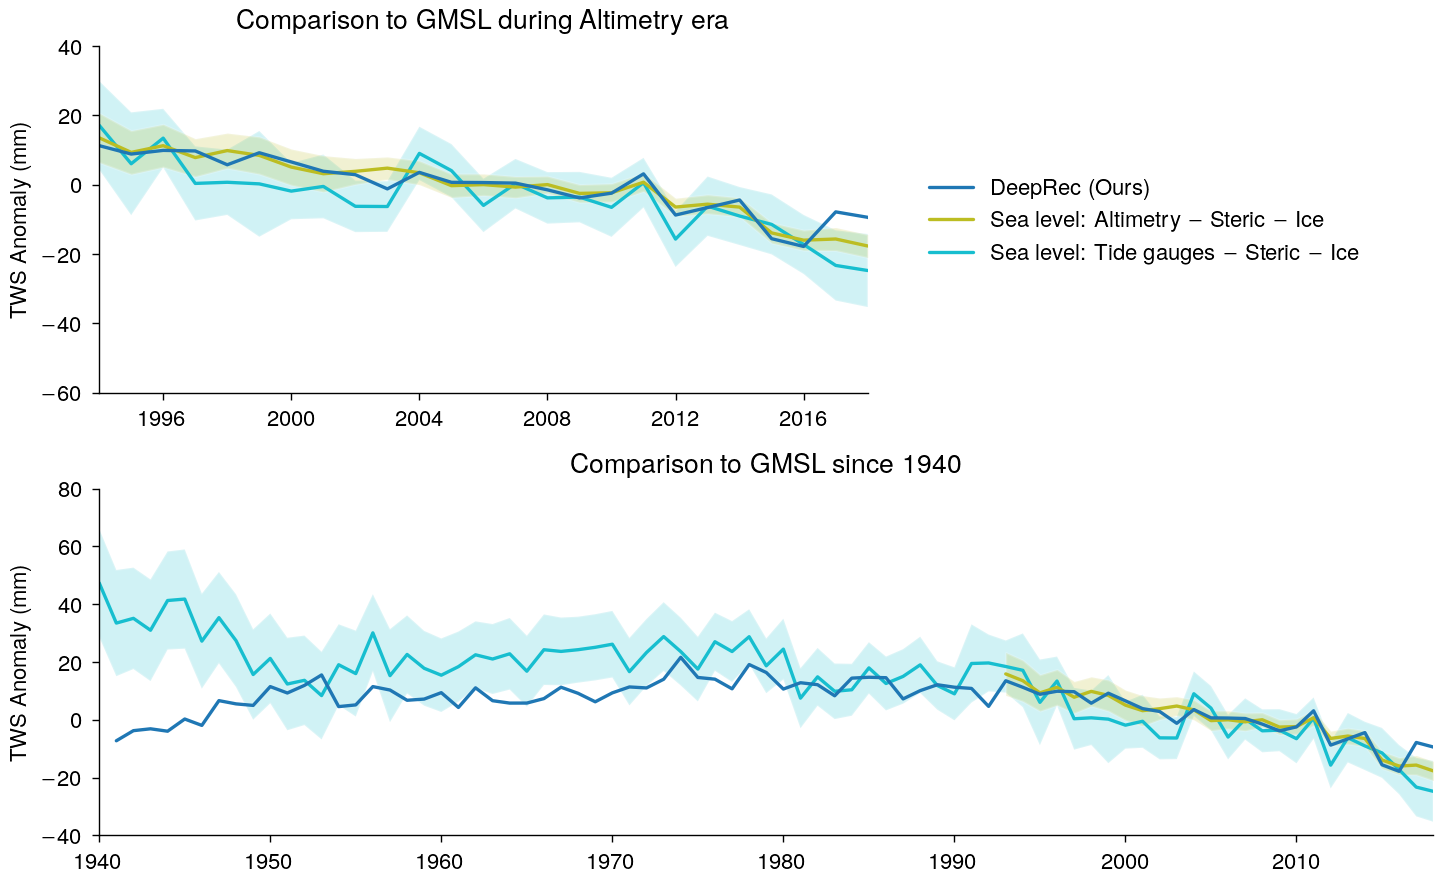

In [16]:
fig = plt.figure(figsize=(7.2, 4.4))
gs = fig.add_gridspec(2, 2, width_ratios=[1.4, 1], hspace=0.05)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, :])

# PLOT 1 (Ours and GRACE, monthly + yearly, Altimetry era)

ax1.fill_between(
    gmsl_dates,
    ubound_gmsl_obs,
    lbound_gmsl_obs,
    facecolor=dark_colors_dict["twsa_gmsl_obs"],
    alpha=0.2,
)
ax1.fill_between(
    gmsl_dates,
    ubound_gmsl_alt,
    lbound_gmsl_alt,
    facecolor=dark_colors_dict["twsa_gmsl_alt"],
    alpha=0.2,
)
l_obs = plot_yearly("twsa_gmsl_obs", ax1)
l_alt = plot_yearly("twsa_gmsl_alt", ax1)
l_ours = plot_yearly("twsa_our", ax1)

# Plot CI


ax1.set(
    xlim=(pd.Timestamp("1994"), pd.Timestamp("2018")),
    ylim=(-60, 40),
    ylabel="TWS Anomaly (mm)",
)
ax1.set_title("Comparison to GMSL during Altimetry era")

# PLOT 2 (Ours and comparison, yearly 1940-now)

loc2 = ticker.MultipleLocator(10)

ax2.fill_between(
    gmsl_dates,
    ubound_gmsl_obs,
    lbound_gmsl_obs,
    facecolor=dark_colors_dict["twsa_gmsl_obs"],
    alpha=0.2,
)
ax2.fill_between(
    gmsl_dates,
    ubound_gmsl_alt,
    lbound_gmsl_alt,
    facecolor=dark_colors_dict["twsa_gmsl_alt"],
    alpha=0.2,
)

plot_yearly("twsa_gmsl_obs", ax2)
plot_yearly("twsa_gmsl_alt", ax2)
# l_humph = plot_yearly("humphrey_gsfc_detrend", ax2, linewidth=1.0)
plot_yearly("twsa_our", ax2)

ax2.set(
    xlim=(pd.Timestamp("1940"), pd.Timestamp("2018")),
    ylim=(-40, 80),
    ylabel="TWS Anomaly (mm)",
)
ax2.set_title("Comparison to GMSL since 1940")
# ax2.yaxis.set_major_locator(loc2)

# Manually sort legend
handles = [
    l_ours,
    l_alt,
    l_obs,
]
fig.legend(handles=handles, loc="center left", bbox_to_anchor=(0.63, 0.75))


## Ability to close the sea level budget

Calculate the error between the reconstructed TWS and the sea level derived TWS

In [17]:
TIME_PERIODS = [
    ("1940", "1959"),
    ("1960", "1979"),
    ("1980", "2001"),
    ("2002", "2018"),
]


In [18]:
# Evaluation variables (remove GMSL)
ds_eval = global_yearly[eval_names]

df_errors = []

for period in TIME_PERIODS:
    # Iterate over different time periods
    ds_true_period = global_yearly.twsa_gmsl_obs.sel(time=slice(*period))
    ds_eval_period = ds_eval.sel(time=slice(*period))
    THRES = 0.5
    n_time = len(ds_eval_period.time)
    for model in ds_eval_period.data_vars:
        n_time_notna = len(ds_eval_period[model].dropna("time", how="all").time)
        # Set all values to NA if less valid timesteps than threshold for current period
        if n_time_notna < 0.5 * n_time:
            ds_eval_period[model][:] = np.nan
    # Calculate the RMSE
    ds_error = metrics.rmse(ds_true_period, ds_eval_period, skipna=True)
    # Convert to data frame
    df_error = (
        ds_error.to_pandas()
        .rename("model")
        .reset_index(name="error")
        .rename(columns={"index": "model"})
    )
    # Add decriptive names
    df_error["model_verbose"] = df_error["model"].map(vars_verbose)

    df_errors.append(df_error)

[(0.0, 40.0)]

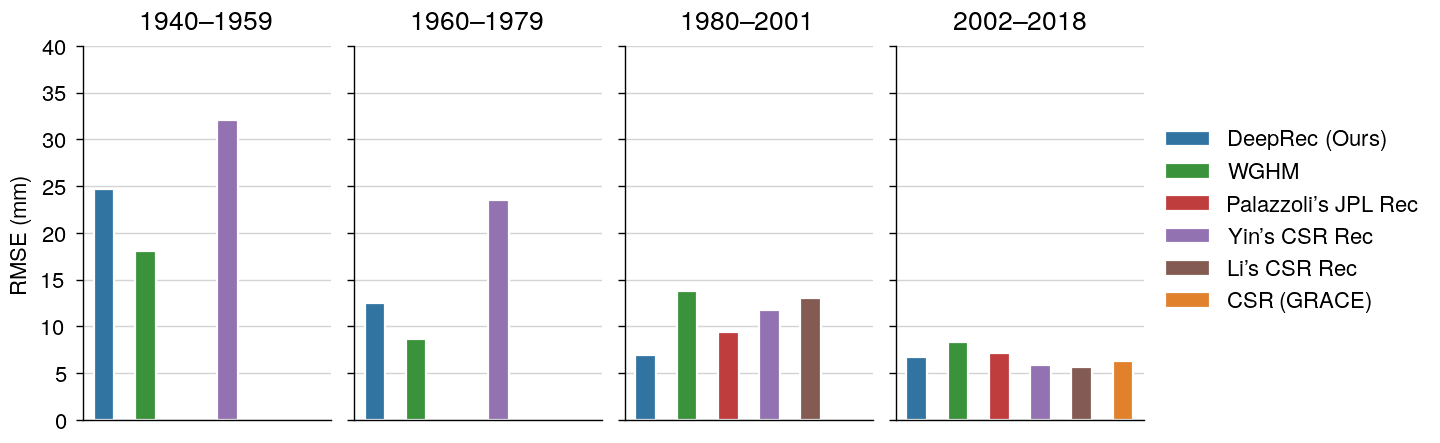

In [19]:
fig, axs = plt.subplots(
    ncols=len(TIME_PERIODS), sharex=True, sharey=True, figsize=(7.2, 2.2)
)


# Plot

for i, (ax, period, df_error) in enumerate(zip(axs, TIME_PERIODS, df_errors)):
    sns.barplot(
        df_error,
        y="error",
        x="model_verbose",
        width=0.5,
        hue="model",
        palette=dark_colors_dict,
        ax=ax,
        legend=True if i == 3 else False,
    )
    ax.set(ylabel="RMSE (mm)", xlabel=None, title=f"{period[0]}--{period[1]}")
    ax.xaxis.set_visible(False)
    ax.yaxis.grid()

# Move legend outside the axes
leg = fig.legend(loc="outside right")
for text in leg.texts:
    text.set_text(vars_verbose[text.get_text()])
axs[3].legend().remove()

axs[0].set(ylim=(0, 40))


## Combine

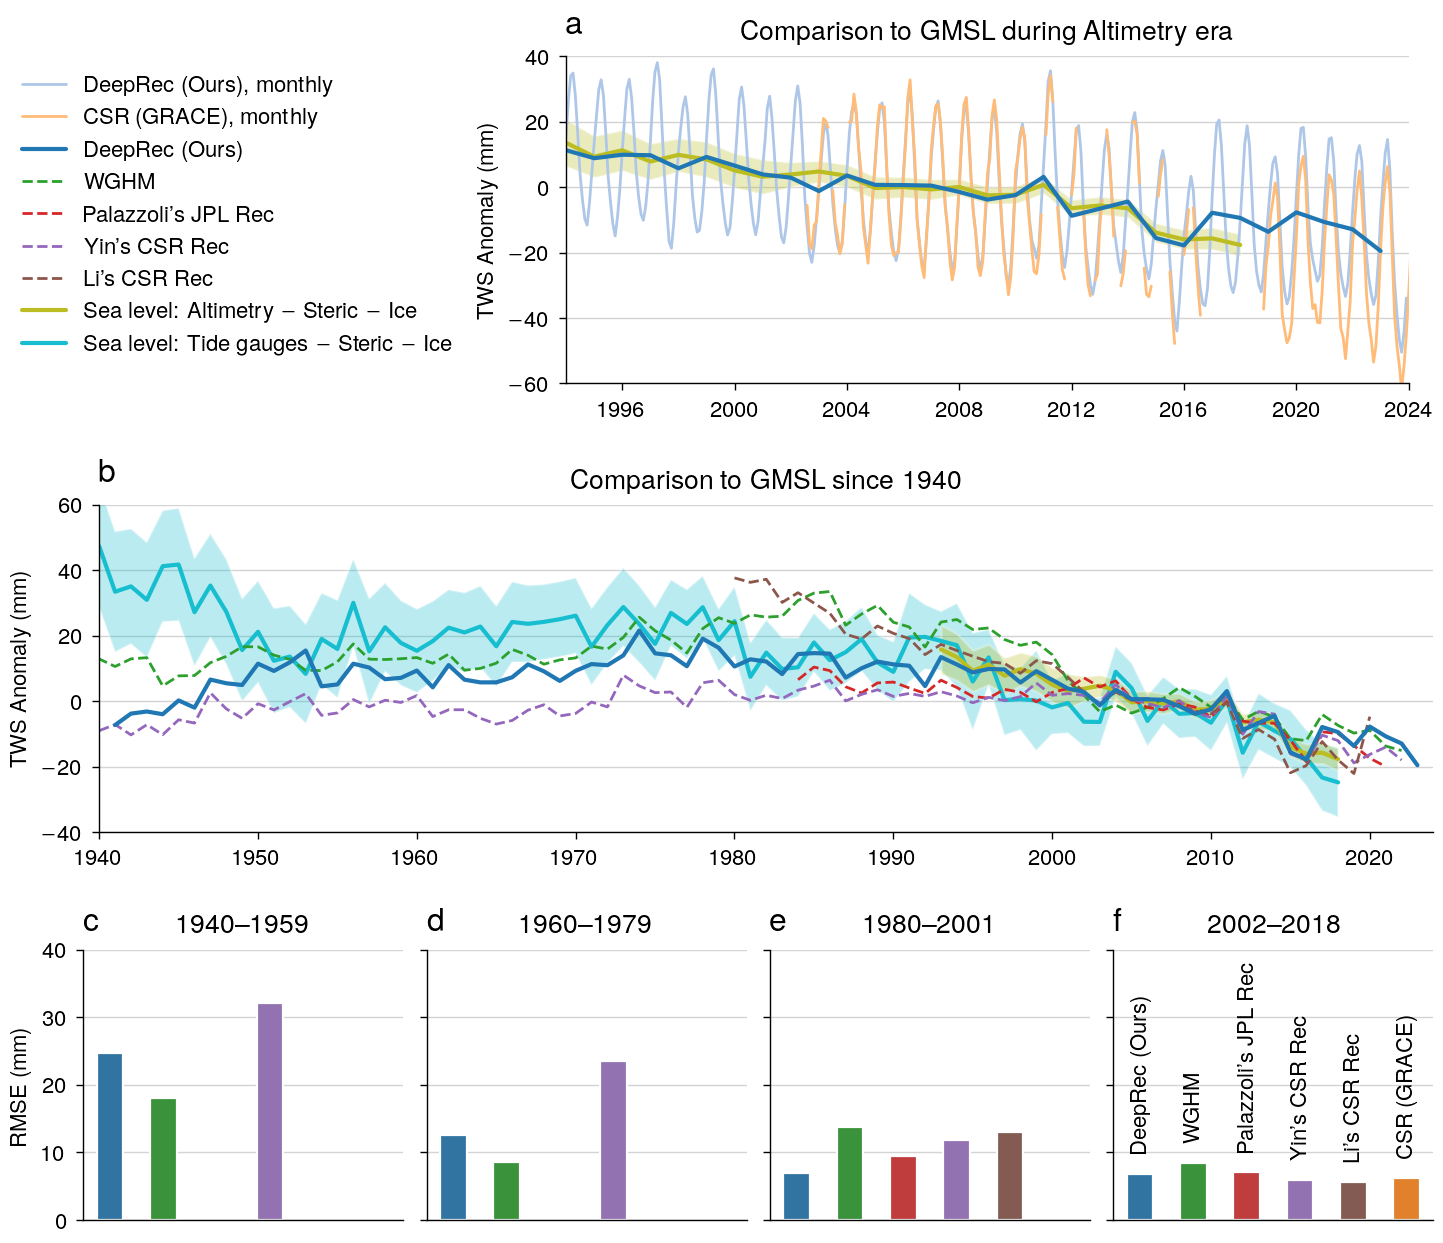

In [20]:
fig = plt.figure(figsize=(7.2, 6.2))
fig_alt, fig_obs, fig_bar = fig.subfigures(
    nrows=3, hspace=0.05, height_ratios=[5, 5, 4]
)
ax_alt = fig_alt.add_subplot()
ax_obs = fig_obs.add_subplot()
axs_bar = fig_bar.subplots(ncols=len(TIME_PERIODS), sharex=True, sharey=True)

### PLOT 1 (Altimetry era) ###

# ax_alt.fill_between(
#     gmsl_dates,
#     ubound_gmsl_obs,
#     lbound_gmsl_obs,
#     facecolor=dark_colors_dict["twsa_gmsl_obs"],
#     alpha=0.3,
# )
ax_alt.fill_between(
    gmsl_dates,
    ubound_gmsl_alt,
    lbound_gmsl_alt,
    facecolor=dark_colors_dict["twsa_gmsl_alt"],
    alpha=0.3,
)
thick_kwargs = dict(linewidth=1.5)
dash_kwargs = dict(linewidth=1.0, linestyle="dashed")

l_ours_monthly = plot_monthly("twsa_our", ax_alt, linewidth=1.0)
l_csr_monthly = plot_monthly(
    "twsa_csr",
    ax_alt,
    linewidth=1.0,
)
# plot_yearly("twsa_gmsl_obs", ax_alt, **thick_kwargs)
plot_yearly("twsa_gmsl_alt", ax_alt, **thick_kwargs)
plot_yearly("twsa_our", ax_alt, **thick_kwargs)

ax_alt.set(
    xlim=(pd.Timestamp("1994"), pd.Timestamp("2024")),
    ylim=(-60, 40),
    ylabel="TWS Anomaly (mm)",
    title="Comparison to GMSL during Altimetry era",
)
ax_alt.yaxis.grid()

### PLOT 2 (1940-now) ###

ci_obs = ax_obs.fill_between(
    gmsl_dates,
    ubound_gmsl_obs,
    lbound_gmsl_obs,
    facecolor=dark_colors_dict["twsa_gmsl_obs"],
    alpha=0.3,
)
ci_alt = ax_obs.fill_between(
    gmsl_dates,
    ubound_gmsl_alt,
    lbound_gmsl_alt,
    facecolor=dark_colors_dict["twsa_gmsl_alt"],
    alpha=0.3,
)
l_obs = plot_yearly("twsa_gmsl_obs", ax_obs, **thick_kwargs)
l_alt = plot_yearly("twsa_gmsl_alt", ax_obs, **thick_kwargs)
l_gap = plot_yearly("twsa_gap", ax_obs, **dash_kwargs)
l_pal = plot_yearly("palazzoli_jpl_full", ax_obs, **dash_kwargs)
l_yin = plot_yearly("yin_csr_full", ax_obs, **dash_kwargs)
l_li = plot_yearly("li_csr_full", ax_obs, **dash_kwargs)
l_ours = plot_yearly("twsa_our", ax_obs, **thick_kwargs)


ax_obs.set(
    xlim=(pd.Timestamp("1940"), pd.Timestamp("2024")),
    ylim=(-40, 60),
    ylabel="TWS Anomaly (mm)",
    title="Comparison to GMSL since 1940",
)
ax_obs.yaxis.grid()

### PLOT 3 (Budget closure barplot) ###

for i, (ax, period, df_error) in enumerate(zip(axs_bar, TIME_PERIODS, df_errors)):
    sns.barplot(
        df_error,
        y="error",
        x="model_verbose",
        width=0.5,
        hue="model",
        palette=dark_colors_dict,
        ax=ax,
        legend=True if i == 3 else False,
    )
    ax.set(ylabel="RMSE (mm)", xlabel=None, title=f"{period[0]}--{period[1]}")
    ax.xaxis.set_visible(False)
    ax.yaxis.grid()

    if i == 3:
        # Add labels within bar plot
        for bars, text in zip(axs_bar[3].containers, df_error.model_verbose):
            axs_bar[3].bar_label(bars, labels=[text], rotation=90, padding=7)

# Move legend outside the axes
# leg = fig_bar.legend(loc="outside right")
# for text in leg.texts:
#     text.set_text(vars_verbose[text.get_text()])
axs_bar[3].legend().remove()
axs_bar[0].set(ylim=(0, 40))


# Add letters
for n, ax in enumerate([ax_alt, ax_obs, *axs_bar]):
    ax.text(
        0.0,
        1.0 + 0.07,
        string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )

# Manually sort legend
handles = [
    l_ours_monthly,
    l_csr_monthly,
    l_ours,
    l_gap,
    l_pal,
    l_yin,
    l_li,
    l_alt,
    l_obs,
]
fig_alt.legend(handles=handles, loc="outside center left")

fig.savefig(FIGURE_DIR / "gmsl_comparison.pdf", backend="pgf")
